# Solver を利用して線形最適化問題を解いてみよう
主婦の問題を簡単にしたものを解いていく。
３種類の食料品と４種類の栄養素の組み合わせを考えていく。

In [1]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals
from IPython.display import display

In [2]:
# 主婦の問題を Solver によって解く

# Data の読み込み
df_n = pd.read_csv('nutrition.csv', index_col='食料品')
df_p = pd.read_csv('price.csv')
print("食料品と栄養素の関係")
display(df_n)
print("食料品の価格")
display(df_p)

食料品と栄養素の関係


,栄養素１,栄養素２,栄養素３,栄養素４
食料品,,,,
食料品１,0,0,90,10
食料品２,10,50,40,70
食料品３,80,0,0,0


食料品の価格


,食料品１,食料品２,食料品３
0,1000,150,300


In [3]:
# 初期設定
np.random.seed(1)
n_p = len(df_n.index)
nn = len(df_n.columns)
pr = list(range(n_p))

In [4]:
# 数理Model 作成
m1 = model_min()
# 目的関数
v1 = {(i):LpVariable('v%d'%(i), cat='Integer', lowBound=0) for i in pr}
# 制約条件
m1 += lpSum(df_p.iloc[0][i] * v1[i] for i in pr)
for j in range(nn):
    m1 += lpSum(v1[i] * df_n.iloc[i][j] for i in range(n_p)) >= 100
m1.solve()

1

In [5]:
# 総Cost 計算
print("最適解")
total_cost = 0
for k, x in v1.items():
    i = k
    print(f"{df_n.index[i]}の個数: {int(value(x))}個")
    total_cost += df_p.iloc[0][i] * value(x)

print(f"総Cost: {int(total_cost)}円")

最適解
食料品１の個数: 0個
食料品２の個数: 3個
食料品３の個数: 1個
総Cost: 750円


## 5-3. 非線形最適化問題を解いてみよう
正方形の形をした土地の最適な長さを求める問題を考える。
- 目的: x の二乗と 1000 との差を最小化する
- 条件: x は正の数

In [6]:
# 二分探索によって f(x) が 0 となる x の値を求める

def f(x):
    return x ** 2 - 1000

In [7]:
# 初期設定
lo = -0.1
hi = 1000.1
eps = 1e-10  # 許容誤差

In [8]:
# 二分探索を実行
count = 0
while hi - lo > eps:
    x = (lo + hi) / 2
    if f(x) >= 0:
        hi = x
    else:
        lo = x
    count += 1

print(f"結果: {hi}")
print(f"探索回数: {count}回")

結果: 31.622776601731587
探索回数: 44回


二分探索：両端から範囲を２つに分けながら、少しずつ絞り込みを行なっていく方法

In [9]:
# Newton法によって f(x) が 0 となる x の値を求める

# Newton法の関数
# x0, eps は Default値
def square_root(y, x0=1, eps=1e-10):
    x = x0
    count = 0
    while abs(x ** 2 - y) > eps:
        x -= (x * x - y) / (2 * x)
        count += 1
    return x, count


# Newton法の実行
x, count = square_root(1000)
print(f"結果: {x}")
print(f"探索回数: {count}回")

結果: 31.622776601684333
探索回数: 9回


Newton法:
関数と x軸との交点を求める手法。関数の値が 0 になる x の値を求める方法として用いられる。

Newton法の法が二分探索に比べて高速に計算ができた。

### 5-4. 日雇いアルバイトの Shift を自動で決める方法について検討してみよう

In [10]:
# Shift 希望表を読み込む
import pandas as pd

def schedules_from_csv(path):
    return pd.read_csv(path, index_col=0)

schedules_from_csv('schedule.csv')

,月朝,月昼,月夜,火朝,火昼,火夜,水朝,水昼,水夜,木朝,木昼,木夜,金朝,金昼,金夜
候補者0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
候補者1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
候補者2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
候補者3,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
候補者4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
候補者5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
候補者6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
候補者7,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0
候補者8,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
候補者9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


読み込んだ Shift希望表になるべく添える形で、アルバイト候補所を割り振るための計算を行なう。

### 5-5. Shift希望を Graph-Network で可視化する方法を学ぼう

In [11]:
# list と set の処理構造を比較する

import numpy as np

print(f"1 ~ 100までの整数を100個乱数生成")
a = np.random.randint(1, 100, 100)
print(a)
l = list(a)
s = set(a)

x = 50

# 下の２行はどちらも同じ結果になる
print(f"50が含まれているか: {x in l}")
print(f"50が含まれているか: {x in s}")

1 ~ 100までの整数を100個乱数生成
[38 13 73 10 76  6 80 65 17  2 77 72  7 26 51 21 19 85 12 29 30 15 51 69
 88 88 95 97 87 14 10  8 64 62 23 58  2  1 61 82  9 89 14 48 73 31 72  4
 71 22 50 58  4 69 25 44 77 27 53 81 42 83 16 65 69 26 99 88  8 27 26 23
 10 68 24 28 38 58 84 39  9 33 35 11 24 16 88 26 72 93 75 63 47 33 89 24
 56 66 78  4]
50が含まれているか: True
50が含まれているか: True


In [12]:
%%time
# list での実行時間
for _ in range(10 ** 6):
    x in l  # list の場合

CPU times: total: 1.03 s
Wall time: 2.87 s


In [13]:
%%time
# set での実行時間
for _ in range(10**6):
    x in s  # set の場合

CPU times: total: 93.8 ms
Wall time: 162 ms


list と set では、Data構造が異なるため、同じ処理でも計算時間に大きな差が生じる。
大枠の Algorithm が同じだとしても、使用する Data構造によって処理時間が大きく変わる。

### 5-9. 最大流問題を解いてみよう
最大流問題の最適解を求める Source-code を実行することによって動作を確認する

In [14]:
from collections import deque
inf = float('inf')

class Graph:
    class __Edge:
        def __init__(self, capacity=1, **args):
            self.capacity = capacity


    def __init__(self, n=0):
        self.__N = n
        self.edges = [{} for _ in range(n)]


    # 辺を追加する関数
    def add_edge(self, u, v, **args):
        self.edges[u][v] = self.__Edge(**args)


    # BFS(幅優先探索)を行う関数
    def bfs(self, src=0):
        n = self.__N
        self.lv = lv = [None]*n
        lv[src] = 0
        q = deque([src]) # BFSではqueueというデータ構造を使用する(Pythonではdequeue)
        while q:
            u = q.popleft()
            for v, e in self.edges[u].items():
                if e.capacity == 0: continue # フローを流すことができない(辺が存在しない)
                if lv[v] is not None: continue # すでにレベルが確定している
                lv[v] = lv[u] + 1
                q.append(v)

    # DFS(深さ優先探索)を行う関数
    def flow_to_sink(self, u, flow_in, sink):
        if u == sink:
            return flow_in
        flow = 0
        for v, e in self.edges[u].items():
            if e.capacity == 0: continue
            if self.lv[v] <= self.lv[u]: continue
            f = self.flow_to_sink(v, min(flow_in, e.capacity), sink)
            if not f: continue
            self.edges[u][v].capacity -= f
            if u in self.edges[v]:
                self.edges[v][u].capacity += f
            else:
                self.add_edge(v, u, capacity=f)
            flow_in -= f
            flow += f
        return flow


    # 最大流が求まるまでBFSとDFSを繰り返し実行する
    def dinic(self, src, sink, visualize=False):
        flow = 0
        while True:
            if visualize:
                self.visualizer(self)
            self.bfs(src)
            if self.lv[sink] is None:
                return flow
            flow += self.flow_to_sink(src, inf, sink)

    # 可視化するための関数をセット
    def set_visualizer(self, visualizer):
        self.visualizer = visualizer

- `.bfs()`: 幅優先探索により頂点の Level を探索する部分
- `flow_to_sink()`: 深さ優先探索により source から sink への flow を探索する部分
- `dinic()`: 上記、２つの関数を繰り返し呼び出すことで、最大流を求める。

<Figure size 1000x500 with 0 Axes>

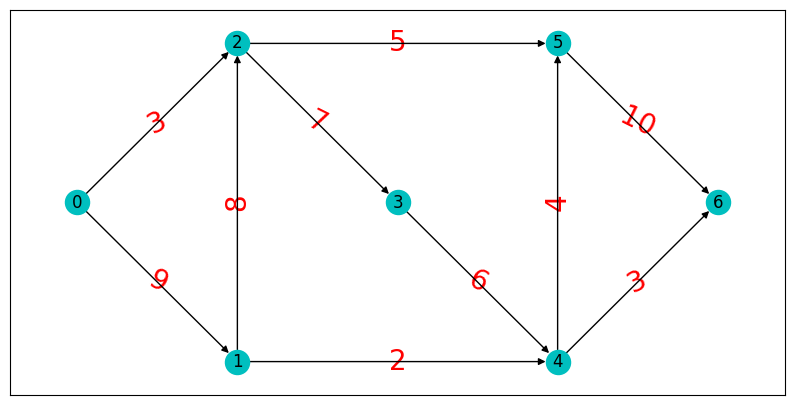

In [15]:
# 最大流問題を解く Algorithm
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# 辺の設定
edges = [
    ((0, 2), 3),
    ((0, 1), 9),
    ((1, 2), 8),
    ((2, 3), 7),
    ((1, 4), 2),
    ((2, 5), 5),
    ((3, 4), 6),
    ((4, 5), 4),
    ((4, 6), 3),
    ((5, 6), 10)
]

# 頂点座標を設定
nodes = [
    (0, 1),
    (1, 0),
    (1, 2),
    (2, 1),
    (3, 0),
    (3, 2),
    (4, 1),
]

n = len(nodes)

# 可視化Graph
graph = nx.DiGraph()

# Graph に頂点番号を追加
graph.add_nodes_from(range(n))

# 頂点座標の情報を Graph に追加しやすい形に整形
pos = dict(enumerate(nodes))

# 最初の状態を描画
plt.figure(figsize=(10, 5))

for (u, v), cap in edges:
    graph.add_edge(u, v, capacity=cap)

labels = nx.get_edge_attributes(graph, 'capacity')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color='r', font_size=20)
nx.draw_networkx(graph, pos=pos, node_color='c')
plt.show()
graph.remove_edges_from([e[0] for e in edges])

最大流は「12」となっている。
source から上下の頂点へ「３」と「９」の容量いっぱいに流すことができていることから、最大流を計算できていそうだと推測される。

この結果の確からしさを確認するため、実際に source から sink へどのように flow が流れたのかを可視化してみる。

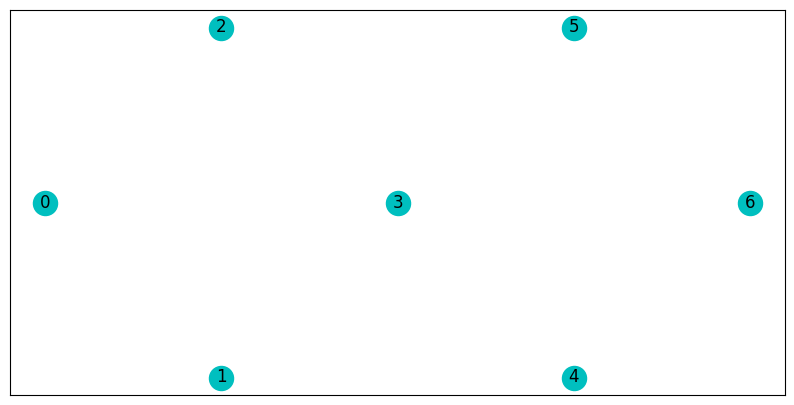

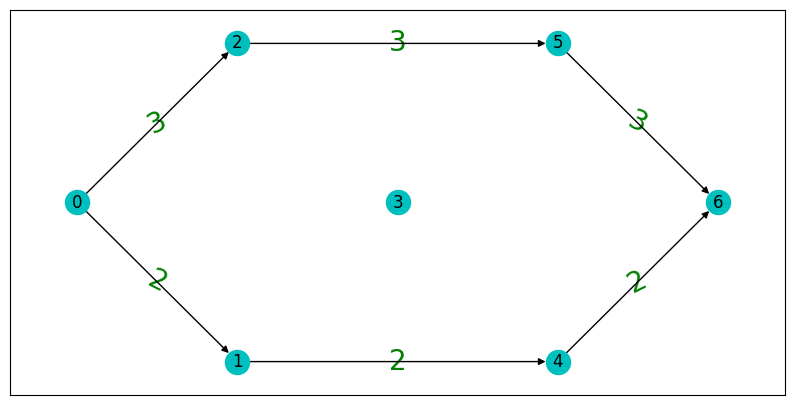

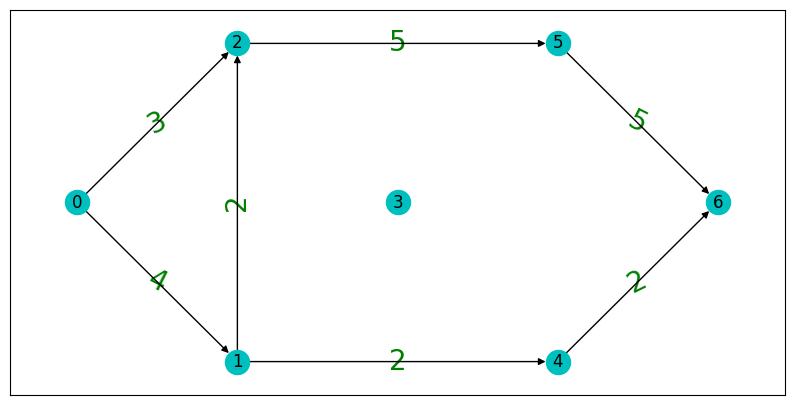

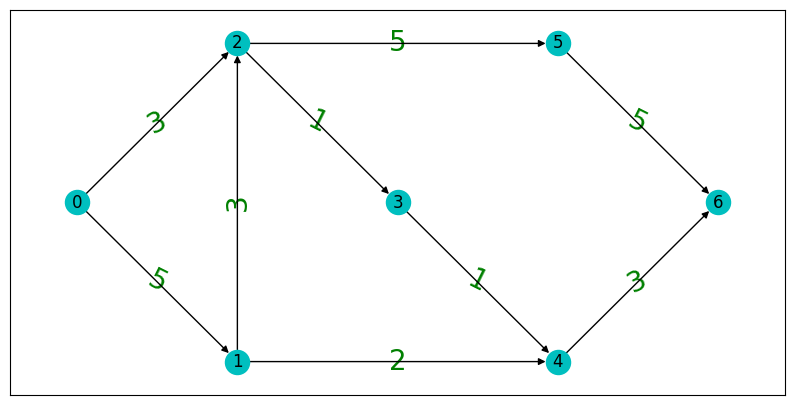

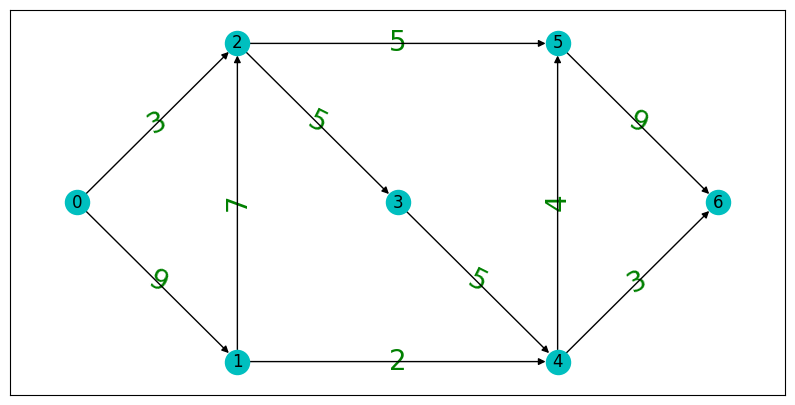

最大流: 12


In [16]:
# 最大流を求める Process を可視化する

# 最大流を解くための Graph を生成
g = Graph(n)

for (u, v), cap in edges:
    g.add_edge(u, v, capacity=cap)  # 辺を追加。


# 途中結果の Flow の様子を描画する関数
def show_progress(q):
    plt.figure(figsize=(10, 5))

    for (u, v), cap in edges:
        e = g.edges[u][v]
        if e.capacity >= cap:
            continue
        graph.add_edge(u, v, capacity=cap - e.capacity)

    labels = nx.get_edge_attributes(graph, 'capacity')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels, font_color='g', font_size=20)
    nx.draw_networkx(graph, pos=pos, node_color='c')
    plt.show()
    graph.remove_edges_from([e[0] for e in edges])


# 可視化するための関数を set
g.set_visualizer(show_progress)

print(f"最大流: {g.dinic(src=0, sink=6, visualize=True)}")

### 5-10. 最大流問題を応用して、Matching問題を解いてみよう
最大流問題を Matching問題に応用する source code を実行して、その動作を確認し、アルバイトの候補者の Shift を決める Matching を行なう。

In [17]:
# Shift の読み込み
import numpy as np
import pandas as pd


def schedules_from_csv(path):
    return pd.read_csv(path, index_col=0)


schedules = schedules_from_csv('schedule.csv')
n, m = schedules.shape
schedules

,月朝,月昼,月夜,火朝,火昼,火夜,水朝,水昼,水夜,木朝,木昼,木夜,金朝,金昼,金夜
候補者0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
候補者1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
候補者2,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
候補者3,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
候補者4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
候補者5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
候補者6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
候補者7,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0
候補者8,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
候補者9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


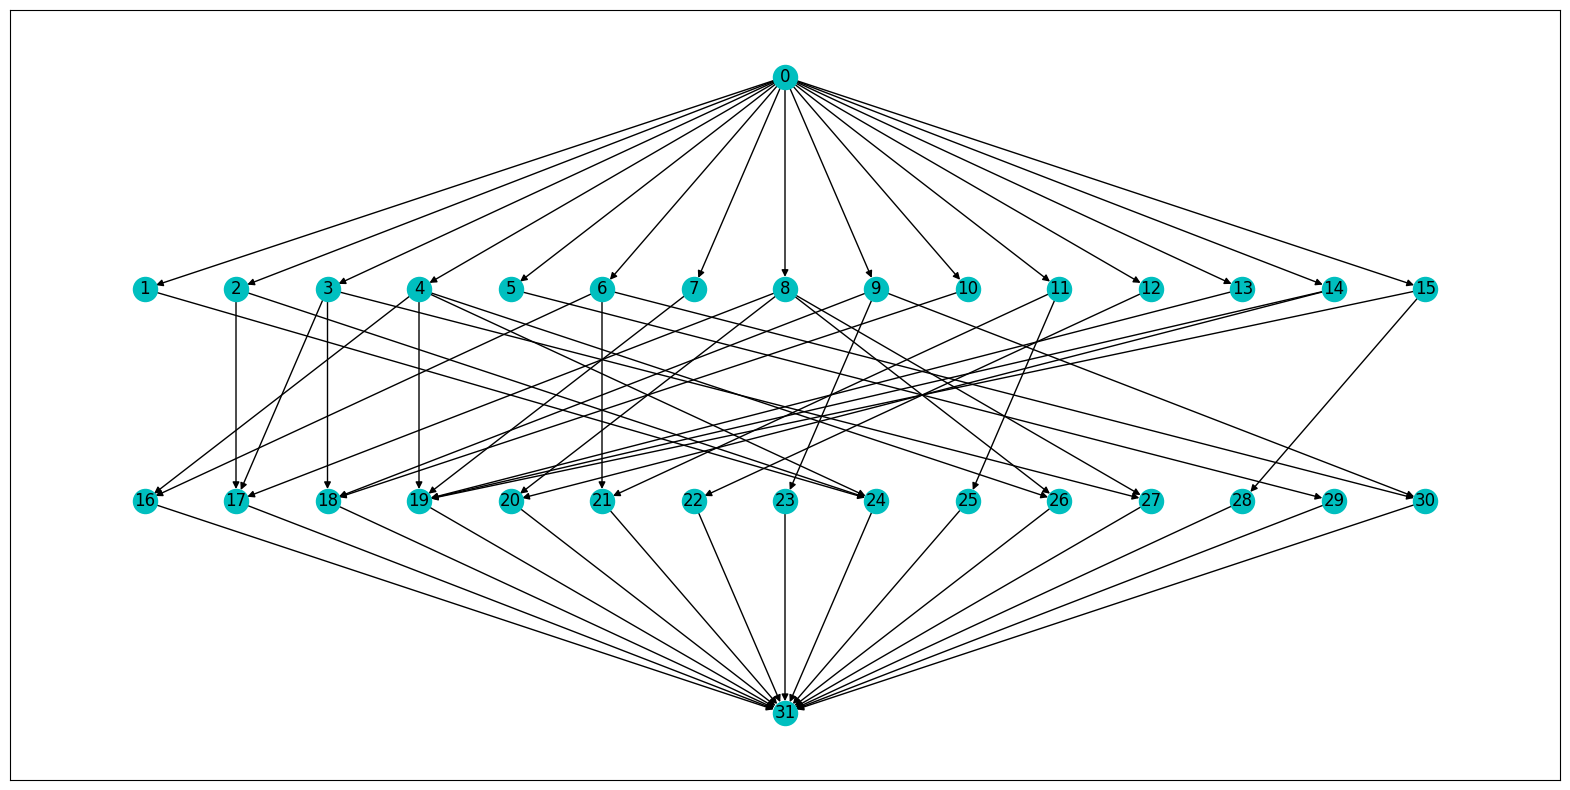

In [18]:
# Shift表を Network として可視化する
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# 可視化用の Graph
graph = nx.DiGraph()

N = n + m + 2
graph.add_nodes_from(range(N))
# n個の頂点を Graph に追加
center = 10
vertices = [(center, 9)] + [(center + (i - n // 2), 6) for i in range(n)] + [(center + (i - m // 2), 3) for i in range(m)] + [(center, 0)]


# 辺の作成
schedules = schedules.values
edges = np.argwhere(schedules)
edges += 1
edges[:, 1] += n
edges1 = np.array([(0, i+1) for i in range(n)]).reshape(-1, 2)
edges2 = np.array([(i+n+1, n+m+1) for i in range(m)]).reshape(-1, 2)
edges = np.vstack([edges1, edges, edges2])

# 頂点座標の情報を Graph に追加しやすい形に整形
pos = dict(enumerate(vertices))

# 辺の追加
for u, v in edges:
    graph.add_edge(u, v, capacity=1)

# 描画
nx.draw_networkx(graph, pos=pos, node_color='c')
plt.show()

可視化した Shit希望表に基づいて、最適な Matching を行なっていく。
辺の capacity はすべて１と考え、Graph class の .dinic() を実行することによって最大流問題を解く

In [19]:
# 最大流問題を解く Algorithm
g = Graph(N)

# 辺を追加
for u, v in edges:
    g.add_edge(u, v, capacity=1)

print(f"最大流: {g.dinic(src=0, sink=N - 1)}")

最大流: 14


最大流の数値は、最大何人が希望の Shift に入れるのかを表す。

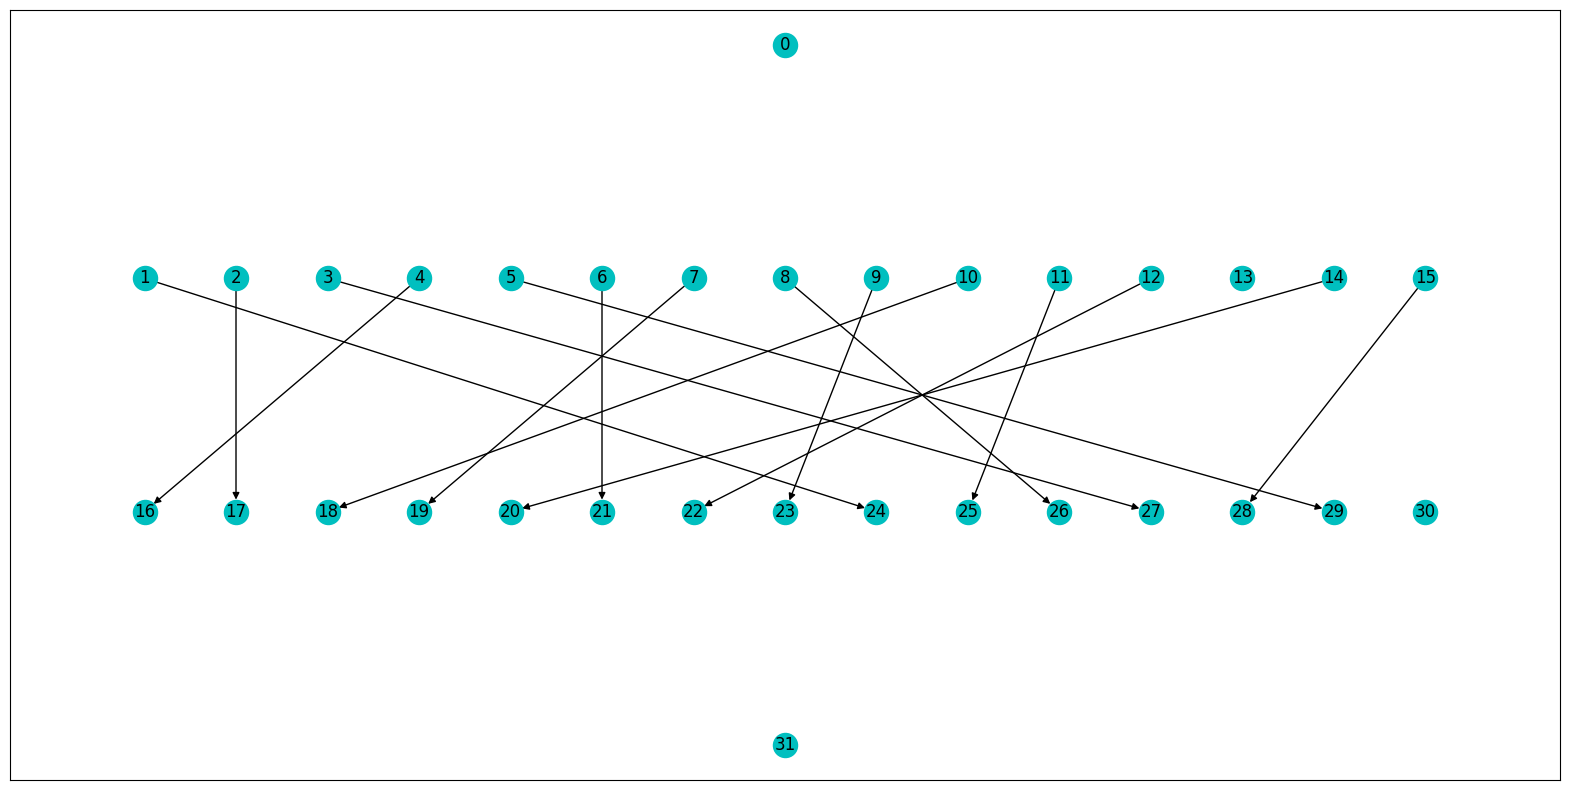

In [20]:
# Matching結果の Network を可視化する
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# 可視化Graph
graph = nx.DiGraph()

N = n + m + 2
graph.add_nodes_from(range(N))
center = 10

# 描画する座標を求める
vertices = [(center, 9)] + [(center + (i-n//2), 6) for i in range(n)] + [(center + (i-m//2), 3) for i in range(m)] + [(center, 0)]

# 辺の作成
edges = np.argwhere(schedules)
edges += 1
edges[:, 1] += n

# 頂点座標の情報Graph に追加しやすい形に整形
pos = dict(enumerate(vertices))

# Shift表の初期化
shift_table = np.zeros(shape=(n, m), dtype=np.int8)

# 辺を追加
for u, v in edges:
    e = g.edges[u][v]
    if e.capacity == 1:  # Matching していない辺は描画しない
        continue
    graph.add_edge(u, v, capacity=1)
    u -= 1  # 従業員の index に変換
    v -= 1 + n  # Shift の index に変換
    shift_table[u, v] = 1


# 描画
nx.draw_networkx(graph, pos=pos, node_color='c')
plt.show()

Shift の最適解が求まった。
アルバイト候補者全員の希望には添えず、なるべく多くの候補者の Matching をした結果、14人の希望に添うことが出来た。

In [21]:
# 結果の Shift を出力する

# DataFrame に変換
shift_table = pd.DataFrame(shift_table)

# Column と Index を設定
idx = [f"候補者{i}" for i in range(n)]
col = [
    f"{day}{time}"
    for day in ['月', '火', '水', '木', '金']
    for time in ['朝', '昼', '夜']
]
shift_table.rename(index=dict(enumerate(idx)),
                   columns=dict(enumerate(col)))

,月朝,月昼,月夜,火朝,火昼,火夜,水朝,水昼,水夜,木朝,木昼,木夜,金朝,金昼,金夜
候補者0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
候補者1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
候補者2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
候補者3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
候補者4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
候補者5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
候補者6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
候補者7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
候補者8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
候補者9,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


「候補者12」以外は全員希望の Schedule通りに Shift に入れたことがわかった。